# K-Means++ Clustering With Comparison to Global Temperature

Saving continents2.csv to continents2 (1).csv
Saving long_format_annual_surface_temp.csv to long_format_annual_surface_temp (1).csv
Saving co2_emissions_kt_by_country.csv to co2_emissions_kt_by_country (1).csv
Saving methane_hist_emissions.csv to methane_hist_emissions (1).csv
Saving annual-change-forest-area.csv to annual-change-forest-area (1).csv


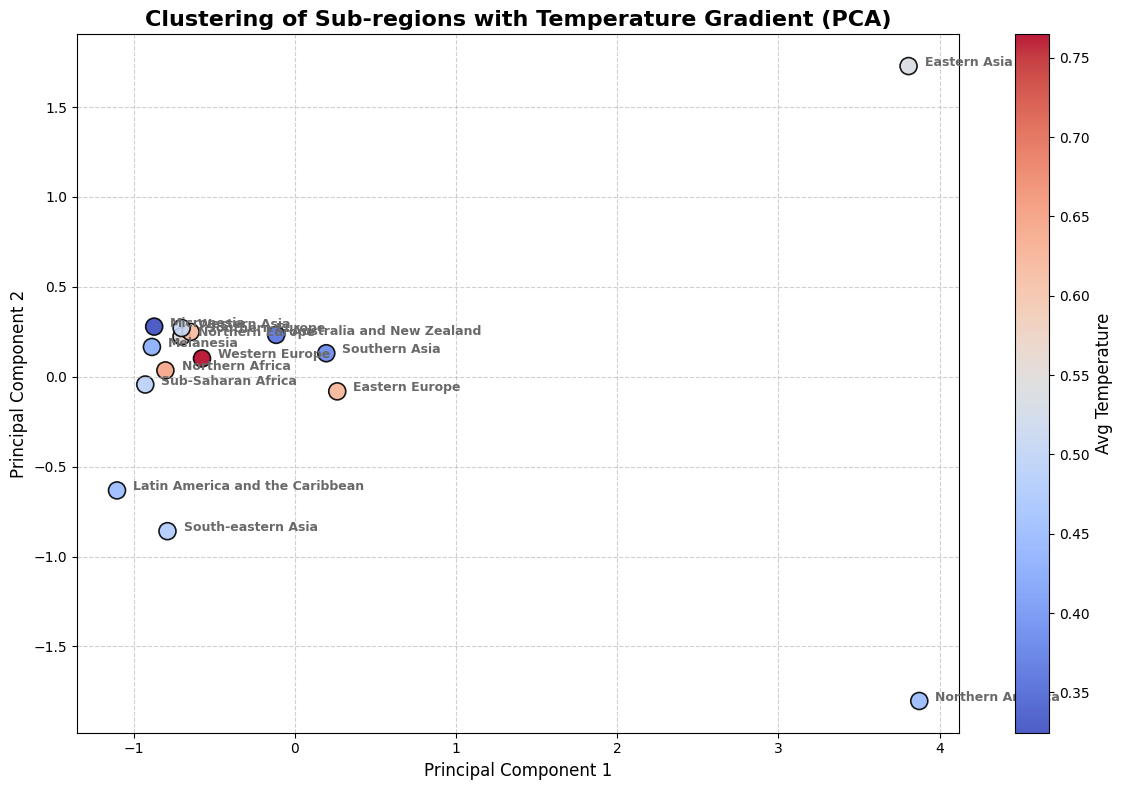

In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#upload CSV's
from google.colab import files
uploaded = files.upload()

#load data
continents_df = pd.read_csv("continents2.csv")
co2_df = pd.read_csv("co2_emissions_kt_by_country.csv")
methane_df = pd.read_csv("methane_hist_emissions.csv")
deforestation_df = pd.read_csv("annual-change-forest-area.csv")
temperature_df = pd.read_csv("long_format_annual_surface_temp.csv")

#country code mappings ---
subregion_map = continents_df[['alpha-3', 'sub-region']].rename(columns={'alpha-3': 'Code', 'sub-region': 'Sub-region'})
country_name_to_code = continents_df.set_index('name')['alpha-3'].to_dict()

#processing CO2
co2_grouped = co2_df.groupby('country_code')['value'].mean().reset_index()
co2_grouped = co2_grouped.rename(columns={'country_code': 'Code', 'value': 'Avg_CO2_Emissions'})

#processing Methane
methane_filtered = methane_df[(methane_df['Sector'] == 'Total excluding LUCF') & (methane_df['Gas'] == 'CH4')]
methane_grouped = methane_filtered.set_index('Country')[[str(year) for year in range(1990, 2019)]].mean(axis=1).reset_index()
methane_grouped.columns = ['Country', 'Avg_Methane_Emissions']
methane_grouped['Code'] = methane_grouped['Country'].map(country_name_to_code)
methane_grouped = methane_grouped.dropna(subset=['Code'])

#processing deforestation
deforestation_grouped = deforestation_df.groupby('Code')['Net forest conversion'].mean().reset_index()
deforestation_grouped = deforestation_grouped.rename(columns={'Net forest conversion': 'Avg_Deforestation'})

#merge by sub-regions
merged = pd.merge(subregion_map, co2_grouped, on='Code', how='left')
merged = pd.merge(merged, methane_grouped[['Code', 'Avg_Methane_Emissions']], on='Code', how='left')
merged = pd.merge(merged, deforestation_grouped, on='Code', how='left')
final_grouped = merged.dropna().groupby('Sub-region')[['Avg_CO2_Emissions', 'Avg_Methane_Emissions', 'Avg_Deforestation']].mean().reset_index()

#process temperature by sub-regions
temperature_df['Country_Clean'] = temperature_df['Country'].str.replace(r',.*', '', regex=True).str.strip()
temperature_df['Code'] = temperature_df['Country_Clean'].map(country_name_to_code)
temperature_df = temperature_df.dropna(subset=['Code'])
temp_with_region = pd.merge(temperature_df, subregion_map, on='Code', how='left')
temp_with_region = temp_with_region.dropna(subset=['Sub-region'])
temp_with_region['Temperature'] = pd.to_numeric(temp_with_region['Temperature'], errors='coerce')
avg_temp_by_subregion = temp_with_region.groupby('Sub-region')['Temperature'].mean().reset_index()
avg_temp_by_subregion = avg_temp_by_subregion.rename(columns={'Temperature': 'Avg_Temperature'})

#merge temp w/ features
final_dataset = pd.merge(final_grouped, avg_temp_by_subregion, on='Sub-region', how='left')
cluster_data = final_dataset.dropna().copy()

#k-Means++ clustering
features = ['Avg_CO2_Emissions', 'Avg_Methane_Emissions', 'Avg_Deforestation']
X = cluster_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
cluster_data['Cluster'] = kmeans.fit_predict(X_scaled)

#PCA projection for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
cluster_data['PCA1'] = X_pca[:, 0]
cluster_data['PCA2'] = X_pca[:, 1]

#plot w/ temp gradient
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    cluster_data['PCA1'],
    cluster_data['PCA2'],
    c=cluster_data['Avg_Temperature'],
    cmap='coolwarm',
    s=150,
    edgecolor='black',
    linewidth=1.2,
    alpha=0.9
)

#point text
for i in range(cluster_data.shape[0]):
    plt.text(
        cluster_data['PCA1'].iloc[i] + 0.1,
        cluster_data['PCA2'].iloc[i],
        cluster_data['Sub-region'].iloc[i],
        fontsize=9,
        weight='bold',
        color='dimgray'
    )

plt.title('Clustering of Sub-regions with Temperature Gradient (PCA)', fontsize=16, weight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
cbar = plt.colorbar(scatter)
cbar.set_label('Avg Temperature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
